In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import xgboost as xgb

# Load the data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submission_df = pd.read_csv('sample_submission.csv')

# Handle missing values
train_df.fillna('', inplace=True)
test_df.fillna('', inplace=True)

# Combine 'prompt' and 'answer' columns
train_texts = train_df['prompt'] + " " + train_df['answer']
test_texts = test_df['prompt'] + " " + test_df['answer']

# Fit the vectorizer on training data
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_texts).toarray()
X_test = vectorizer.transform(test_texts).toarray()

# Labels
y_train = train_df['AI']
mode_label = y_train.mode()[0]
y_train.replace('', mode_label, inplace=True)

# Instantiate LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels
y_train = label_encoder.fit_transform(y_train)

# Split the data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Implement SMOTE for balancing the dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_split, y_train_split)



C:\Users\Administrator\AppData\Local\Temp\ipykernel_13880\1048130776.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  train_df.fillna('', inplace=True)


Logistic Regression Accuracy: 0.6333


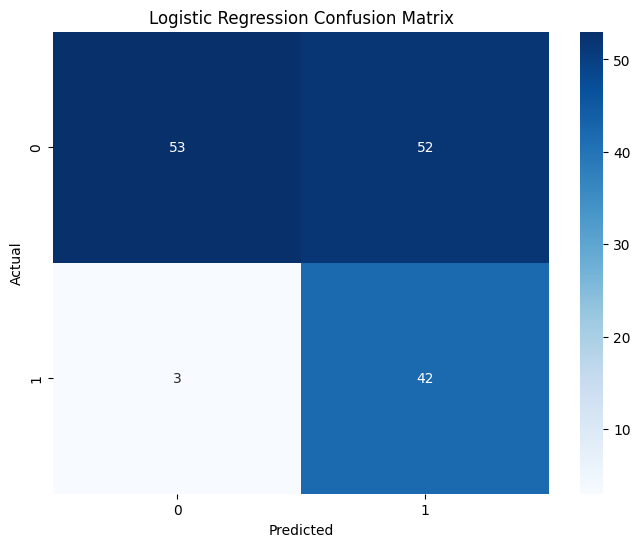

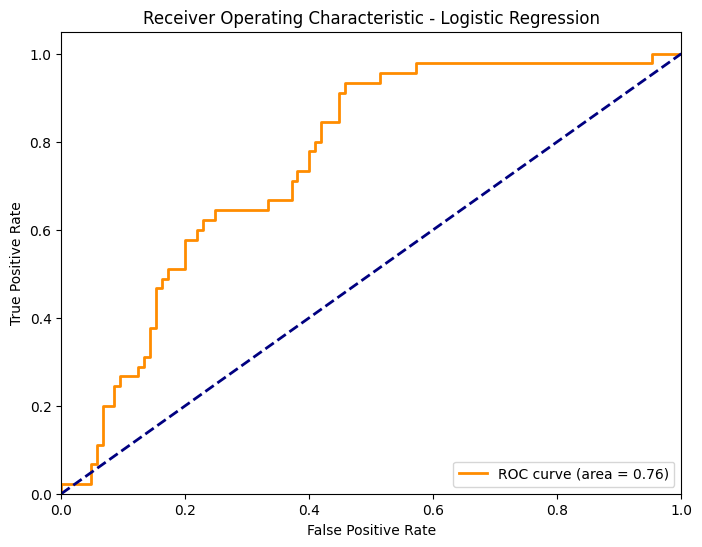

In [24]:
# Logistic Regression with class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))

model_lr = LogisticRegression(class_weight=class_weights)
model_lr.fit(X_train_resampled, y_train_resampled)
# Calculate accuracy for Logistic Regression
y_val_pred_lr = model_lr.predict(X_val_split)
accuracy_lr = accuracy_score(y_val_split, y_val_pred_lr)
print(f"Logistic Regression Accuracy: {accuracy_lr:.4f}")

# Confusion Matrix for Logistic Regression
conf_matrix_lr = confusion_matrix(y_val_split, y_val_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

# ROC Curve for Logistic Regression
y_val_prob_lr = model_lr.predict_proba(X_val_split)[:, 1]
fpr, tpr, _ = roc_curve(y_val_split, y_val_prob_lr)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.5736 - loss: 0.6886 - val_accuracy: 0.6667 - val_loss: 0.6571
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.7995 - loss: 0.5596 - val_accuracy: 0.7400 - val_loss: 0.5945
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9376 - loss: 0.1958 - val_accuracy: 0.7667 - val_loss: 0.6726
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9707 - loss: 0.0972 - val_accuracy: 0.7867 - val_loss: 0.6492
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9803 - loss: 0.0669 - val_accuracy: 0.7667 - val_loss: 0.6971
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7441 - loss: 0.5963 
Neural Network Validation Accuracy: 0.7400


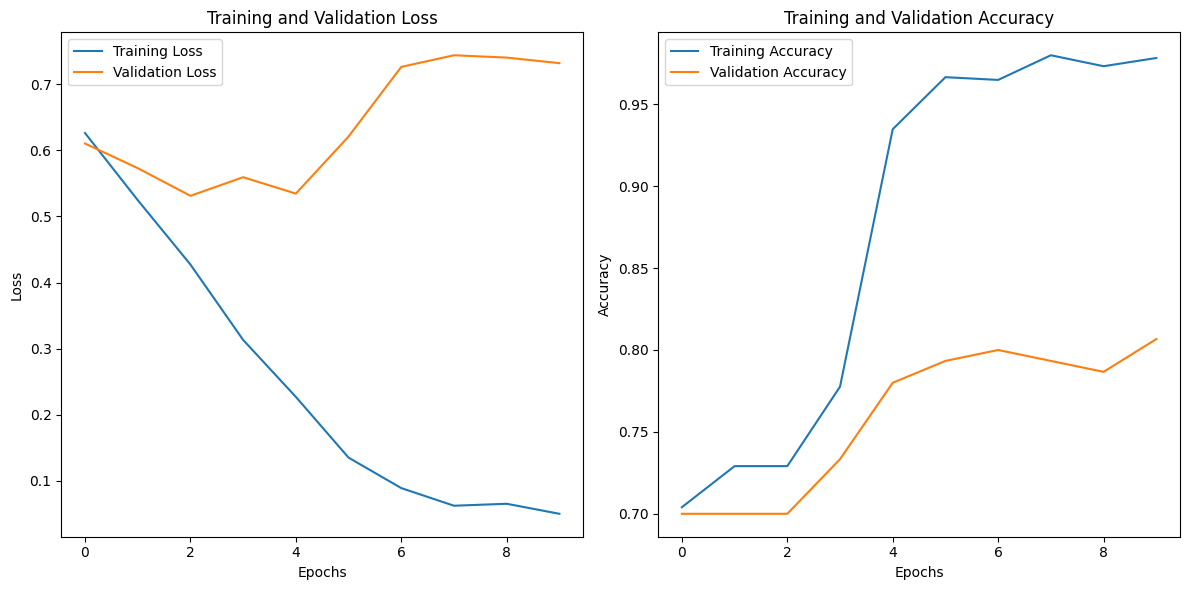

In [25]:
# Neural Network Model
def create_nn_model(input_shape, layers=[512, 256, 128], dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    for layer in layers:
        model.add(Dense(layer, activation='relu', input_shape=(input_shape,)))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model_nn = create_nn_model(input_shape=X_train_split.shape[1])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_nn.fit(X_train_resampled, y_train_resampled, epochs=10, batch_size=32, validation_data=(X_val_split, y_val_split), callbacks=[early_stopping])
# Calculate accuracy for Neural Network
val_loss, val_accuracy = model_nn.evaluate(X_val_split, y_val_split)
print(f"Neural Network Validation Accuracy: {val_accuracy:.4f}")

# Training History Plot for Neural Network
history_dict = history.history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
# XGBoost Model
model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_train_resampled, y_train_resampled)
# Calculate accuracy for XGBoost
y_val_pred_xgb = model_xgb.predict(X_val_split)
accuracy_xgb = accuracy_score(y_val_split, y_val_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb:.4f}")

# Test data preprocessing
X_test = vectorizer.transform(test_texts).toarray()

# Logistic Regression Predictions
y_test_pred_lr = model_lr.predict(X_test)

# Neural Network Predictions
y_test_pred_nn = model_nn.predict(X_test)
y_test_pred_nn = (y_test_pred_nn > 0.5).astype(int)

# XGBoost Predictions
y_test_pred_xgb = model_xgb.predict(X_test)

# Create a copy of the submission dataframe for each model's predictions
submission_lr = submission_df[['Id']].copy()
submission_nn = submission_df[['Id']].copy()
submission_xgb = submission_df[['Id']].copy()

# Add predictions to each copy and rename the column to 'Category'
submission_lr['Category'] = y_test_pred_lr
submission_nn['Category'] = y_test_pred_nn
submission_xgb['Category'] = y_test_pred_xgb

# Save each to a separate CSV file
submission_lr.to_csv('completed_submission_lr.csv', index=False)
submission_nn.to_csv('completed_submission_nn.csv', index=False)
submission_xgb.to_csv('completed_submission_xgb.csv', index=False)

submission_lr.head(), submission_nn.head(), submission_xgb.head()

XGBoost Accuracy: 0.8133
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


(    Id  Category
 0  710         1
 1  487         0
 2  136         1
 3   44         1
 4  627         1,
     Id  Category
 0  710         0
 1  487         0
 2  136         1
 3   44         1
 4  627         0,
     Id  Category
 0  710         1
 1  487         0
 2  136         1
 3   44         1
 4  627         0)

In [27]:
print(train_df['AI'].value_counts())


AI
0.0    541
1.0    207
Name: count, dtype: int64
